In [1]:
# Import necessary packages
import requests
import geopandas as gpd
import pandas as pd
from urllib.parse import urlencode
import os
from shapely.geometry import Point

In [2]:
from tqdm import tqdm

In [3]:
!cd C:\Users\hyungmin\GIS_project\KakaoProject

In [4]:
# 파일 경로
path = 'KakaoProject/data'

In [5]:
# 서울 500m 격자 데이터 받아오기
seoul_grid_gpd = gpd.read_file('data/seoul_500m_grid.shp')
#seoul_grid_gpd = gpd.read_file(os.path.join(path,'seoul_500m_grid.shp'))

In [6]:
# 좌표계 확인
seoul_grid_gpd.crs

<Projected CRS: EPSG:5179>
Name: KGD2002 / Unified CS
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Republic of Korea (South Korea) - onshore and offshore.
- bounds: (122.71, 28.6, 134.28, 40.27)
Coordinate Operation:
- name: Korea Unified Belt
- method: Transverse Mercator
Datum: Korean Geodetic Datum 2002
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [7]:
# 격자데이터의 중심점으로 데이터 변환
seoul_grid_gpd['geometry'] = seoul_grid_gpd.geometry.centroid

In [8]:
# 좌표계 ->경위로로 변환 epsg:4326
seoul_grid_gpd = seoul_grid_gpd.to_crs('epsg:4326')

In [9]:
seoul_grid_gpd.geometry.x

0       126.766975
1       126.766930
2       126.766886
3       126.772635
4       126.772591
           ...    
2629    127.180118
2630    127.180099
2631    127.180080
2632    127.185856
2633    127.185837
Length: 2634, dtype: float64

In [10]:
seoul_grid_gpd.geometry.y

0       37.549316
1       37.553822
2       37.558329
3       37.549351
4       37.553857
          ...    
2629    37.564678
2630    37.569185
2631    37.573692
2632    37.546666
2633    37.551173
Length: 2634, dtype: float64

# 카카오 API 호출 부분

In [11]:
my_kakao_key = '키를 입력하세요'

# REST API 키
REST_API_KEY = my_kakao_key


In [12]:
seoul_grid_gpd.head()

,GRID_500M_,f4_int,geometry
0,다사35a50a,NaN,POINT (126.76697 37.54932)
1,다사35a50b,0.0,POINT (126.76693 37.55382)
2,다사35a51a,8.0,POINT (126.76689 37.55833)
3,다사35b50a,NaN,POINT (126.77263 37.54935)
4,다사35b50b,NaN,POINT (126.77259 37.55386)


In [14]:
df = pd.DataFrame()

In [15]:
for idx, row in tqdm(seoul_grid_gpd.iterrows()):
    # 검색 파라미터
    place_params = {
        'query': '스타벅스',
        'x': row.geometry.x,
        'y': row.geometry.y,
        'radius': 360,
        'category_group_code' : 'CE7',
        'sort': 'distance'
    }
    # 파라미터 인코딩
    query_string = urlencode(place_params)
    
    # 전체 URL 조립
    url = f'https://dapi.kakao.com/v2/local/search/keyword.json?{query_string}'
    
    # 헤더 설정
    headers = {
        'Authorization': f'KakaoAK {REST_API_KEY}'
    }

    # 요청 보내기
    response = requests.get(url, headers=headers)
    # 응답 출력
    if response.status_code == 200:
        data = response.json()
        #print(data)
    else:
        print(f"Error {response.status_code}: {response.text}")

    
    if data['meta']['pageable_count'] == 0:
        continue
    
    else:
        # documents 리스트 추출
        places = data['documents']
    
        # pandas DataFrame으로 변환
        df1 = pd.DataFrame(places)
        
        # 위도(y), 경도(x)를 float으로 변환하고, geometry 컬럼 생성
        df1['x'] = df1['x'].astype(float)
        df1['y'] = df1['y'].astype(float)
        df1['geometry'] = df1.apply(lambda row: Point(row['x'], row['y']), axis=1)
    
        df = pd.concat([df, df1], ignore_index=True)

    

2634it [03:16, 13.41it/s]


In [17]:
# 2번 검색 된 것
df[df.duplicated(keep=False)]

,address_name,category_group_code,category_group_name,category_name,distance,id,phone,place_name,place_url,road_address_name,x,y,geometry


In [18]:
# 중복값 제거 (버퍼가 맞물려서 2번 검색되는 경우도 있어서)
df = df[~df.duplicated(['place_name','address_name'])]

In [19]:
df.head()

,address_name,category_group_code,category_group_name,category_name,distance,id,phone,place_name,place_url,road_address_name,x,y,geometry
0,서울 강서구 방화동 886,CE7,카페,음식점 > 카페 > 커피전문점 > 스타벅스,334,1205763710,1522-3232,스타벅스 김포공항국제선점,http://place.map.kakao.com/1205763710,서울 강서구 하늘길 38,126.800504,37.566045,POINT (126.800503805011 37.5660449035456)
2,서울 강서구 방화동 645-6,CE7,카페,음식점 > 카페 > 커피전문점 > 스타벅스,359,697145793,1522-3232,스타벅스 김포공항DT점,http://place.map.kakao.com/697145793,서울 강서구 개화동로 517,126.806055,37.566302,POINT (126.80605506972896 37.56630192697181)
4,서울 강서구 공항동 32-3,CE7,카페,음식점 > 카페 > 커피전문점 > 스타벅스,273,1001458936,1522-3232,스타벅스 송정역점,http://place.map.kakao.com/1001458936,서울 강서구 공항대로 38,126.811485,37.561008,POINT (126.81148453212424 37.5610083651335)
6,서울 강서구 방화동 293-4,CE7,카페,음식점 > 카페 > 커피전문점 > 스타벅스,277,482613052,1522-3232,스타벅스 방화DT,http://place.map.kakao.com/482613052,서울 강서구 방화대로 375,126.816488,37.574457,POINT (126.81648812269275 37.57445728526807)
8,서울 강서구 마곡동 728-234,CE7,카페,음식점 > 카페 > 커피전문점 > 스타벅스,233,1143075069,1522-3232,스타벅스 마곡역,http://place.map.kakao.com/1143075069,서울 강서구 공항대로 168,126.825997,37.559344,POINT (126.82599715501443 37.55934398119595)


In [105]:
# 서울시를 벗어난 카페를 제거해야함, 버퍼가 서울 밖에도 닿아서

In [20]:
# 'address_name' 열의 앞 2글자가 '서울'이 아닌 행만 필터링
seoul_starbucks_df = df[df['address_name'].str[:2].eq('서울')]

In [21]:
gdf01 = gpd.GeoDataFrame(seoul_starbucks_df, geometry='geometry', crs='EPSG:4326')

In [22]:
gdf01

,address_name,category_group_code,category_group_name,category_name,distance,id,phone,place_name,place_url,road_address_name,x,y,geometry
0,서울 강서구 방화동 886,CE7,카페,음식점 > 카페 > 커피전문점 > 스타벅스,334,1205763710,1522-3232,스타벅스 김포공항국제선점,http://place.map.kakao.com/1205763710,서울 강서구 하늘길 38,126.800504,37.566045,POINT (126.8005 37.56604)
2,서울 강서구 방화동 645-6,CE7,카페,음식점 > 카페 > 커피전문점 > 스타벅스,359,697145793,1522-3232,스타벅스 김포공항DT점,http://place.map.kakao.com/697145793,서울 강서구 개화동로 517,126.806055,37.566302,POINT (126.80606 37.5663)
4,서울 강서구 공항동 32-3,CE7,카페,음식점 > 카페 > 커피전문점 > 스타벅스,273,1001458936,1522-3232,스타벅스 송정역점,http://place.map.kakao.com/1001458936,서울 강서구 공항대로 38,126.811485,37.561008,POINT (126.81148 37.56101)
6,서울 강서구 방화동 293-4,CE7,카페,음식점 > 카페 > 커피전문점 > 스타벅스,277,482613052,1522-3232,스타벅스 방화DT,http://place.map.kakao.com/482613052,서울 강서구 방화대로 375,126.816488,37.574457,POINT (126.81649 37.57446)
8,서울 강서구 마곡동 728-234,CE7,카페,음식점 > 카페 > 커피전문점 > 스타벅스,233,1143075069,1522-3232,스타벅스 마곡역,http://place.map.kakao.com/1143075069,서울 강서구 공항대로 168,126.825997,37.559344,POINT (126.826 37.55934)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,서울 강동구 고덕동 353-23,CE7,카페,음식점 > 카페 > 커피전문점 > 스타벅스,227,1371888894,,스타벅스 이케아강동점,http://place.map.kakao.com/1371888894,서울 강동구 고덕비즈밸리로 51,127.157333,37.566660,POINT (127.15733 37.56666)
1046,서울 강동구 고덕동 210-1,CE7,카페,음식점 > 카페 > 커피전문점 > 스타벅스,270,1422544505,1522-3232,스타벅스 상일동역점,http://place.map.kakao.com/1422544505,서울 강동구 고덕로 399,127.170727,37.557542,POINT (127.17073 37.55754)
1048,서울 강동구 상일동 501,CE7,카페,음식점 > 카페 > 커피전문점 > 스타벅스,37,22105090,1522-3232,스타벅스 상일동점,http://place.map.kakao.com/22105090,서울 강동구 상일로10길 36,127.174258,37.550882,POINT (127.17426 37.55088)
1049,서울 강동구 강일동 723,CE7,카페,음식점 > 카페 > 커피전문점 > 스타벅스,222,1170670329,1522-3232,스타벅스 강일역점,http://place.map.kakao.com/1170670329,서울 강동구 고덕로 429,127.173495,37.557485,POINT (127.17349 37.55749)


<Axes: >

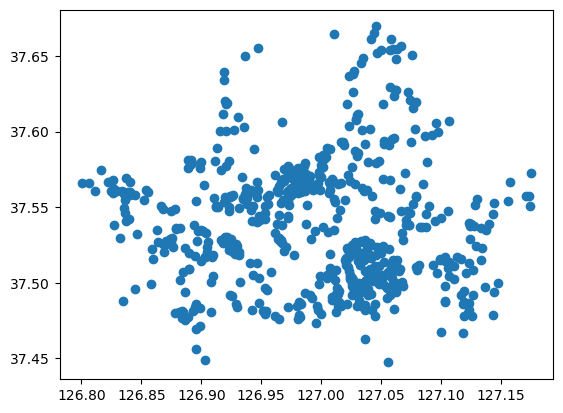

In [23]:
gdf01.plot()

In [24]:
seoul_starbucks_df.to_csv('data/서울스벅.csv')